In [20]:
import pandas as pd
import numpy as np


%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [21]:
# data = pd.DataFrame()

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
data = pd.read_csv('magic_stompy2018.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

In [10]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', 0)
data.set_value(now, 'life', 0)
data.set_value(now, 'opponents_life', 20)
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', 3)
data.set_value(now, 'land rating', 4)

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'steel life champion', 1)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 2)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 1)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 0)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')

In [11]:
data.mean()

won                        0.508475
life                       8.161017
opponents_life             8.915254
deck_size                 60.000000
starting lands             2.813559
druid of the cowl          0.101695
llanowar elves             0.898305
steel life champion        0.949153
vine mare                  0.830508
blanchwood armor           0.101695
lifecrafters bestiary      0.271186
natures way                0.118644
plummet                    0.220339
rabid bite                 0.559322
titanic growth             0.118644
verdant rebirth            0.186441
gigantosaurus              0.322034
majestic myriarch          0.118644
verdurous gearhulk         0.084746
scaled behemoth            0.084746
ghalta                     0.186441
land rating                3.033898
walking ballista           0.135593
colossal majesty           0.474576
aggressive mamoth          0.000000
rhonas                     0.355932
mouth                      0.000000
blossoming defense         0

In [16]:
# creatures = ['oketra', 'rhonas', 'serpopard', 'pacifist', 'baloth pup', 'mouth', 'croc',
# 'exemplar', 'defiant greatmaw', 'glorybound initiate', 'initiates companion',]

# removal = ['gideons reproach', 'reprisal', 'declare in stone', 'prepare']

# data['creatures_total'] = data[creatures].sum(axis=1)
# data['removal_total'] = data[removal].sum(axis=1)

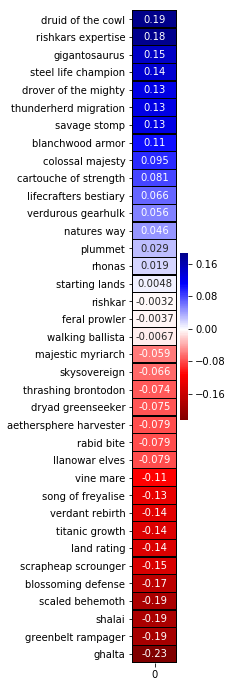

In [12]:
meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

winning_cards = data[cards].corrwith(data['won'])
winning_cards = pd.DataFrame(winning_cards).dropna().sort_values(0, ascending=False)

plt.figure(figsize=(1,12))

sns.heatmap(winning_cards,
           annot=True, cmap='seismic_r', linecolor='black',
           linewidths=.25, center=0)

In [13]:
from scipy import stats
sleep = []
for i in data.select_dtypes(include=[np.number]).drop(['life', 'opponents_life'], axis=1).columns:
    c = stats.pearsonr(data['won'], data[i])
    if c[1] < .15:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
0,ghalta,-0.225743,0.085590
1,greenbelt rampager,-0.190519,0.148353


In [14]:
cards = [
    'drover of the mighty',
    'druid of the cowl',
    'feral prowler',
    'dryad greenseeker',
    'greenbelt rampager',
    'llanowar elves',
    'mouth',
    'rishkar',
    'steel life champion',
    'thrashing brontodon',
    'vine mare',
    'walking ballista',
    'aethersphere harvester',
    'lifecrafters bestiary',
    'skysovereign',
    'scrapheap scrounger',
    'blanchwood armor',
    'blossoming defense',
    'cartouche of strength',
    'colossal majesty',
    'natures way',
    'plummet',
    'rabid bite',
    'song of freyalise',
    'titanic growth',
    'verdant rebirth',
    'vivien reid',
    'aggressive mamoth',
    'ghalta',
    'gigantosaurus',
    'majestic myriarch',
    'rhonas',
    'scaled behemoth',
    'shalai',
    'verdurous gearhulk',
]

In [15]:
combinations = pd.DataFrame()

for i in cards:
    for j in cards:
        if i > j:
            combinations[i + ' + ' + j] = data[i] + data[j]

In [16]:
from scipy import stats
sleep = []
for i in combinations.columns:
    c = stats.pearsonr(data['won'], combinations[i])
    if c[1] < .1:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
22,scaled behemoth + ghalta,-0.315381,0.014970
1,greenbelt rampager + ghalta,-0.295304,0.023169
24,shalai + ghalta,-0.291382,0.025150
25,shalai + scaled behemoth,-0.278749,0.032527
23,shalai + greenbelt rampager,-0.268328,0.039896
9,titanic growth + ghalta,-0.266150,0.041599
3,scrapheap scrounger + ghalta,-0.262386,0.044683
4,song of freyalise + ghalta,-0.261247,0.045652
13,verdant rebirth + ghalta,-0.245028,0.061421
8,titanic growth + blossoming defense,-0.239363,0.067868


In [17]:
# Machine learning

In [18]:
x = data[cards]
y = data['won']

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,21),
    'min_samples_leaf': [1,2,3,4,5,10],
    'min_samples_split': np.arange(2,6),
}

clf = DecisionTreeClassifier()

grid = GridSearchCV(clf, param_grid=param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

print('Mean:', cv.mean())
print('Std dev:', cv.std())

Mean: 0.46851851851851856
Std dev: 0.18423701708301957


# Template

In [ ]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', )
data.set_value(now, 'life', )
data.set_value(now, 'opponents_life', )
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', )
data.set_value(now, 'land rating', )

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 0)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 0)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')